In [6]:
# Step 1: Data Preparation — Load image filepaths & labels, create folds, numeric labels

import os
import pandas as pd
from sklearn.model_selection import StratifiedKFold

main_folder = r'G:\Conference Paper\Dataset'

data = []

# Loop through disease folders and class subfolders to gather filepaths and labels
for disease_folder in ['colon_image_sets', 'lung_image_sets']:
    disease_path = os.path.join(main_folder, disease_folder)
    
    for class_folder in os.listdir(disease_path):
        class_path = os.path.join(disease_path, class_folder)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
                    img_path = os.path.join(class_path, filename)
                    label = class_folder
                    data.append({
                        'filepath': img_path,
                        'label': label
                    })

# Create DataFrame
df = pd.DataFrame(data)

# Map string labels to numeric labels
label_map = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
df['label_num'] = df['label'].map(label_map)

print(f'Total images loaded: {len(df)}')
print(df['label'].value_counts())

# Function to create stratified folds
def create_folds(dataframe, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = []
    X = dataframe['filepath']
    y = dataframe['label_num']
    for train_idx, test_idx in skf.split(X, y):
        train_df = dataframe.iloc[train_idx].reset_index(drop=True)
        test_df = dataframe.iloc[test_idx].reset_index(drop=True)
        folds.append((train_df, test_df))
    return folds

# Split into lung-only, colon-only, combined datasets
lung_df = df[df['label'].str.startswith('lung_')].reset_index(drop=True)
colon_df = df[df['label'].str.startswith('colon_')].reset_index(drop=True)
combined_df = df.copy()

lung_folds = create_folds(lung_df)
colon_folds = create_folds(colon_df)
combined_folds = create_folds(combined_df)

print(f"Lung dataset size: {len(lung_df)}")
print(f"Colon dataset size: {len(colon_df)}")
print(f"Combined dataset size: {len(combined_df)}")


Total images loaded: 25000
label
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_n       5000
lung_scc     5000
Name: count, dtype: int64
Lung dataset size: 15000
Colon dataset size: 10000
Combined dataset size: 25000


In [8]:
# Step 2: Data Generator with on-the-fly loading and preprocessing (128×128 resize + normalize)

from tensorflow.keras.utils import Sequence
from PIL import Image
import numpy as np

class ImageDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indices]
        
        images = []
        labels = batch_df['label_num'].values
        
        for filepath in batch_df['filepath']:
            img = Image.open(filepath).convert('RGB')
            img = img.resize((128, 128))
            img_array = np.array(img) / 255.0
            images.append(img_array)
        
        X = np.stack(images)
        y = labels
        
        return X, y

# Usage example on fold 0 lung data:
train_df, test_df = lung_folds[0]
train_gen = ImageDataGenerator(train_df, batch_size=32, shuffle=True)
test_gen = ImageDataGenerator(test_df, batch_size=32, shuffle=False)

# Test batch shapes
X_batch, y_batch = train_gen[0]
print(f"Train batch X shape: {X_batch.shape}, y shape: {y_batch.shape}")



   


Train batch X shape: (32, 128, 128, 3), y shape: (32,)


In [10]:
# Step 3: Deep feature extraction with transfer learning (saving features for Step 4)

import tensorflow as tf
from tensorflow.keras.applications import MobileNet, VGG16, VGG19, DenseNet169, DenseNet201
from tensorflow.keras.models import Model
import numpy as np
from tqdm import tqdm
import os

def get_feature_extractor(model_name='MobileNet'):
    input_shape = (128, 128, 3)
    base_model = None

    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        output = tf.keras.layers.Flatten()(base_model.output)
    elif model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
        output = tf.keras.layers.Flatten()(base_model.output)
    elif model_name == 'MobileNet':
        base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
        output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    elif model_name == 'DenseNet169':
        base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
        output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    elif model_name == 'DenseNet201':
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
        output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

    model = Model(inputs=base_model.input, outputs=output)
    return model

def extract_features(generator, model):
    features = []
    labels = []

    for i in tqdm(range(len(generator)), desc="Extracting features"):
        X_batch, y_batch = generator[i]
        feat_batch = model.predict(X_batch, verbose=0)
        features.append(feat_batch)
        labels.append(y_batch)

    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

def save_features(features, labels, prefix):
    os.makedirs(os.path.dirname(prefix), exist_ok=True)
    np.save(prefix + '_X.npy', features)
    np.save(prefix + '_y.npy', labels)

# Example: Extract & save features for fold 0 of lung dataset
if __name__ == "__main__":
    model_name = 'MobileNet'
    feature_extractor = get_feature_extractor(model_name)

    train_df, test_df = lung_folds[0]
    train_gen = ImageDataGenerator(train_df, batch_size=32, shuffle=False)
    test_gen = ImageDataGenerator(test_df, batch_size=32, shuffle=False)

    print(f"Extracting train features with {model_name}...")
    X_train_feat, y_train = extract_features(train_gen, feature_extractor)
    print(f"Extracting test features with {model_name}...")
    X_test_feat, y_test = extract_features(test_gen, feature_extractor)

    # Save extracted features to disk for later reuse in Step 4
    feature_save_prefix = r'G:\Conference Paper\features\Mobilenet_lung_fold0'
    save_features(X_train_feat, y_train, feature_save_prefix + '_train')
    save_features(X_test_feat, y_test, feature_save_prefix + '_test')

    print(f"Features saved at {feature_save_prefix}_*.npy")



   
 
   

Extracting train features with MobileNet...


Extracting features: 100%|██████████| 422/422 [04:22<00:00,  1.61it/s]


Extracting test features with MobileNet...


Extracting features: 100%|██████████| 47/47 [00:28<00:00,  1.63it/s]


Features saved at G:\Conference Paper\features\Mobilenet_lung_fold0_*.npy


In [14]:
# Step 4 + Step 5: Training and High-Performance Filtering of Classifiers

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Load features
feature_path_prefix = r'G:\Conference Paper\features\Mobilenet_lung_fold0'
X_train = np.load(f"{feature_path_prefix}_train_X.npy")
y_train = np.load(f"{feature_path_prefix}_train_y.npy")
X_test = np.load(f"{feature_path_prefix}_test_X.npy")
y_test = np.load(f"{feature_path_prefix}_test_y.npy")

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Label encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --------- 1. Classic ML Models ---------
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, kernel='rbf', random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

trained_models = {}
ml_results = {}

for name, model in classifiers.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    print(f"✅ {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test_enc, y_pred, target_names=[str(c) for c in le.classes_]))
    ml_results[name] = acc
    trained_models[name] = model

# --------- 2. Deep Neural Network Model ---------
print("\n🔧 Training Deep Neural Network...")

dnn_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(np.unique(y_train_enc)), activation='softmax')
])
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
dnn_model.fit(X_train, y_train_enc, validation_data=(X_test, y_test_enc), epochs=50, batch_size=64, callbacks=[early_stop], verbose=2)

y_pred_dnn = np.argmax(dnn_model.predict(X_test), axis=1)
acc_dnn = accuracy_score(y_test_enc, y_pred_dnn)
print(f"✅ DNN Accuracy: {acc_dnn:.4f}")
print(classification_report(y_test_enc, y_pred_dnn, target_names=[str(c) for c in le.classes_]))
ml_results['DeepNN'] = acc_dnn
trained_models['DeepNN'] = dnn_model

# --------- 3. Hybrid Models (PCA + SVM and PCA + MLP) ---------
print("\n🔧 Training Hybrid Models (PCA + SVM / PCA + MLP)...")

pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

hybrid_models = {
    'PCA+SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'PCA+MLP': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
}

for name, model in hybrid_models.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train_pca, y_train_enc)
    y_pred = model.predict(X_test_pca)
    acc = accuracy_score(y_test_enc, y_pred)
    print(f"✅ {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test_enc, y_pred, target_names=[str(c) for c in le.classes_]))
    ml_results[name] = acc
    trained_models[name] = model

# --------- 4. Ranking and Summary (Step 5) ---------
print("\n📊 Ranking Models by Accuracy:")
sorted_results = sorted(ml_results.items(), key=lambda x: x[1], reverse=True)
for rank, (name, acc) in enumerate(sorted_results, 1):
    print(f"{rank}. {name}: {acc:.4f}")

top_3_models = [name for name, _ in sorted_results[:3]]
print(f"\n✅ Top 3 Models Selected for Ensemble/Next Step: {top_3_models}")


Train shape: (13500, 1024), Test shape: (1500, 1024)

🔧 Training RandomForest...
✅ RandomForest Accuracy: 0.9640
              precision    recall  f1-score   support

           2       0.94      0.95      0.95       500
           3       0.99      1.00      1.00       500
           4       0.95      0.94      0.95       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500


🔧 Training SVM...
✅ SVM Accuracy: 0.9747
              precision    recall  f1-score   support

           2       0.98      0.95      0.96       500
           3       1.00      1.00      1.00       500
           4       0.95      0.98      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500


🔧 Training LogisticRegression...
✅ LogisticRegression Accuracy: 0.9740
           

C:\Users\O M A R\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:38:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Accuracy: 0.9827
              precision    recall  f1-score   support

           2       0.97      0.97      0.97       500
           3       1.00      1.00      1.00       500
           4       0.98      0.97      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500


🔧 Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245606
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 1020
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ LightGBM Accuracy: 0.9780
          

C:\Users\O M A R\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


211/211 - 4s - 19ms/step - accuracy: 0.9493 - loss: 0.1366 - val_accuracy: 0.9687 - val_loss: 0.0875
Epoch 2/50
211/211 - 2s - 11ms/step - accuracy: 0.9749 - loss: 0.0715 - val_accuracy: 0.9767 - val_loss: 0.0635
Epoch 3/50
211/211 - 2s - 7ms/step - accuracy: 0.9790 - loss: 0.0555 - val_accuracy: 0.9760 - val_loss: 0.0653
Epoch 4/50
211/211 - 3s - 12ms/step - accuracy: 0.9815 - loss: 0.0482 - val_accuracy: 0.9767 - val_loss: 0.0642
Epoch 5/50
211/211 - 3s - 12ms/step - accuracy: 0.9844 - loss: 0.0406 - val_accuracy: 0.9893 - val_loss: 0.0376
Epoch 6/50
211/211 - 1s - 7ms/step - accuracy: 0.9868 - loss: 0.0331 - val_accuracy: 0.9827 - val_loss: 0.0477
Epoch 7/50
211/211 - 2s - 8ms/step - accuracy: 0.9912 - loss: 0.0245 - val_accuracy: 0.9780 - val_loss: 0.0651
Epoch 8/50
211/211 - 2s - 8ms/step - accuracy: 0.9910 - loss: 0.0257 - val_accuracy: 0.9860 - val_loss: 0.0503
Epoch 9/50
211/211 - 2s - 7ms/step - accuracy: 0.9901 - loss: 0.0274 - val_accuracy: 0.9807 - val_loss: 0.0578
Epoch 10

 Rank              Model  Accuracy   Type
    1                MLP    0.9913     ML
    2             DeepNN    0.9893   Deep
    3          PCA + MLP    0.9893 Hybrid
    4          PCA + SVM    0.9860 Hybrid
    5            XGBoost    0.9827     ML
    6           LightGBM    0.9780     ML
    7                SVM    0.9747     ML
    8 LogisticRegression    0.9740     ML
    9       RandomForest    0.9640     ML


C:\Users\O M A R\AppData\Local\Temp\ipykernel_2016\2469545925.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df_sorted, palette='viridis')


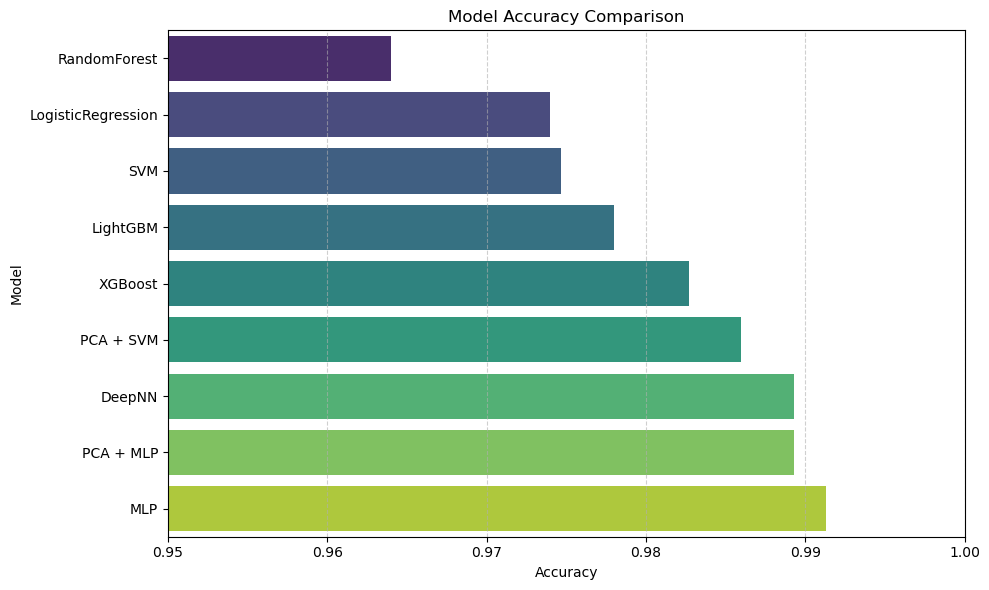

In [18]:
# Tabular Representation
import pandas as pd

# Data with model types
data = {
    'Rank': list(range(1, 10)),
    'Model': [
        'MLP', 'DeepNN', 'PCA + MLP', 'PCA + SVM',
        'XGBoost', 'LightGBM', 'SVM', 'LogisticRegression', 'RandomForest'
    ],
    'Accuracy': [
        0.9913, 0.9893, 0.9893, 0.9860,
        0.9827, 0.9780, 0.9747, 0.9740, 0.9640
    ],
    'Type': [
        'ML',        # MLP is a classical ML model
        'Deep',      # Deep Neural Network
        'Hybrid',    # PCA + MLP
        'Hybrid',    # PCA + SVM
        'ML',        # XGBoost
        'ML',        # LightGBM
        'ML',        # SVM
        'ML',        # LogisticRegression
        'ML'         # RandomForest
    ]
}

# Create DataFrame and display
df = pd.DataFrame(data)
print(df.to_string(index=False))

# Visualization (Bar Chart)

import matplotlib.pyplot as plt
import seaborn as sns

# Ranking data
model_names = [
    'MLP', 'DeepNN', 'PCA + MLP', 'PCA + SVM',
    'XGBoost', 'LightGBM', 'SVM', 'LogisticRegression', 'RandomForest'
]
accuracies = [
    0.9913, 0.9893, 0.9893, 0.9860,
    0.9827, 0.9780, 0.9747, 0.9740, 0.9640
]

# Create DataFrame for better plotting (optional)
import pandas as pd
df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

# Sort for visual clarity
df_sorted = df.sort_values(by='Accuracy', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=df_sorted, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0.95, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [28]:
pip install scikeras

In [40]:
# Step 6: Ensemble Voting Code

In [52]:
#  Useage of a wrapper class for PCA+MLP and PCA+SVM

from sklearn.base import BaseEstimator, ClassifierMixin

class PCAModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, pca, model):
        self.pca = pca
        self.model = model
    
    def fit(self, X, y):
        X_pca = self.pca.transform(X)
        self.model.fit(X_pca, y)
        return self
    
    def predict(self, X):
        X_pca = self.pca.transform(X)
        return self.model.predict(X_pca)
    
    def predict_proba(self, X):
        X_pca = self.pca.transform(X)
        return self.model.predict_proba(X_pca)

In [56]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.base import BaseEstimator, ClassifierMixin

# --- Wrapper for PCA + MLP ---
class PCA_MLP_Wrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, pca, mlp):
        self.pca = pca
        self.mlp = mlp
    def fit(self, X, y):
        X_pca = self.pca.fit_transform(X)
        self.mlp.fit(X_pca, y)
        return self
    def predict(self, X):
        X_pca = self.pca.transform(X)
        return self.mlp.predict(X_pca)
    def predict_proba(self, X):
        X_pca = self.pca.transform(X)
        return self.mlp.predict_proba(X_pca)

# --- Define PCA + MLP hybrid ---
pca_for_mlp = PCA(n_components=100, random_state=42)
mlp_for_pca = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
pca_mlp = PCA_MLP_Wrapper(pca=pca_for_mlp, mlp=mlp_for_pca)

# --- Define vanilla MLP ---
mlp_clf = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)

# --- Define DeepCNN model wrapped with scikeras ---
def create_deepnn():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

deepnn_clf = KerasClassifier(model=create_deepnn, epochs=50, batch_size=32, verbose=0)

# --- Build VotingClassifier ---
estimators = [
    ('MLP', mlp_clf),
    ('DeepCNN', deepnn_clf),
    ('PCA_MLP', pca_mlp)
]

voting_clf_hard = VotingClassifier(estimators=estimators, voting='hard')
voting_clf_hard.fit(X_train, y_train_enc)
y_pred_hard = voting_clf_hard.predict(X_test)
print("Hard Voting Accuracy:", accuracy_score(y_test_enc, y_pred_hard))
print(classification_report(y_test_enc, y_pred_hard, target_names=[str(c) for c in le.classes_]))

voting_clf_soft = VotingClassifier(estimators=estimators, voting='soft')
voting_clf_soft.fit(X_train, y_train_enc)
y_pred_soft = voting_clf_soft.predict(X_test)
print("Soft Voting Accuracy:", accuracy_score(y_test_enc, y_pred_soft))
print(classification_report(y_test_enc, y_pred_soft, target_names=[str(c) for c in le.classes_]))


C:\Users\O M A R\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Hard Voting Accuracy: 0.994
              precision    recall  f1-score   support

           2       0.99      0.99      0.99       500
           3       1.00      1.00      1.00       500
           4       0.99      0.99      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



C:\Users\O M A R\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Soft Voting Accuracy: 0.992
              precision    recall  f1-score   support

           2       0.99      0.98      0.99       500
           3       1.00      1.00      1.00       500
           4       0.98      0.99      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



In [64]:
#  Final Model Selection & Evaluation

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, mean_squared_error, confusion_matrix, roc_auc_score, roc_curve
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt

# ---------- Wrapper for PCA + MLP ----------
class PCA_MLP_Wrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, pca, mlp):
        self.pca = pca
        self.mlp = mlp
    def fit(self, X, y):
        X_pca = self.pca.fit_transform(X)
        self.mlp.fit(X_pca, y)
        return self
    def predict(self, X):
        X_pca = self.pca.transform(X)
        return self.mlp.predict(X_pca)
    def predict_proba(self, X):
        X_pca = self.pca.transform(X)
        return self.mlp.predict_proba(X_pca)

# ---------- Define Deep Neural Network (as MobileNet alternative) ----------
def create_deepnn():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

deepnn_clf = KerasClassifier(model=create_deepnn, epochs=50, batch_size=32, verbose=0)

# ---------- Define Other Models ----------
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
pca_model = PCA(n_components=100, random_state=42)
mlp_hybrid = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
pca_mlp = PCA_MLP_Wrapper(pca=pca_model, mlp=mlp_hybrid)

# ---------- Ensemble Voting Classifier ----------
estimators = [
    ('MLP', mlp_clf),
    ('DeepNN', deepnn_clf),
    ('PCA_MLP', pca_mlp)
]

soft_voting = VotingClassifier(estimators=estimators, voting='soft')
soft_voting.fit(X_train, y_train_enc)

# ---------- Predictions ----------
y_pred = soft_voting.predict(X_test)
y_proba = soft_voting.predict_proba(X_test)

# ---------- Evaluation ----------
accuracy = accuracy_score(y_test_enc, y_pred)
precision = precision_score(y_test_enc, y_pred, average='weighted')
recall = recall_score(y_test_enc, y_pred, average='weighted')
f1 = f1_score(y_test_enc, y_pred, average='weighted')
mae = mean_absolute_error(y_test_enc, y_pred)
mse = mean_squared_error(y_test_enc, y_pred)
rmse = np.sqrt(mse)
conf_mat = confusion_matrix(y_test_enc, y_pred)

print(f"✅ Final Soft Voting Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"MSE:       {mse:.4f}")
print(f"RMSE:      {rmse:.4f}")
print("\nConfusion Matrix:")
print(conf_mat)

# ---------- ROC Curve & AUC (only for binary or handle multi-class with one-vs-rest) ----------
if len(le.classes_) == 2:
    auc = roc_auc_score(y_test_enc, y_proba[:, 1])
    fpr, tpr, _ = roc_curve(y_test_enc, y_proba[:, 1])
    print(f"AUC: {auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

C:\Users\O M A R\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Final Soft Voting Model Accuracy: 0.9940
Precision: 0.9940
Recall:    0.9940
F1 Score:  0.9940
MAE:       0.0120
MSE:       0.0240
RMSE:      0.1549

Confusion Matrix:
[[495   0   5]
 [  0 500   0]
 [  4   0 496]]


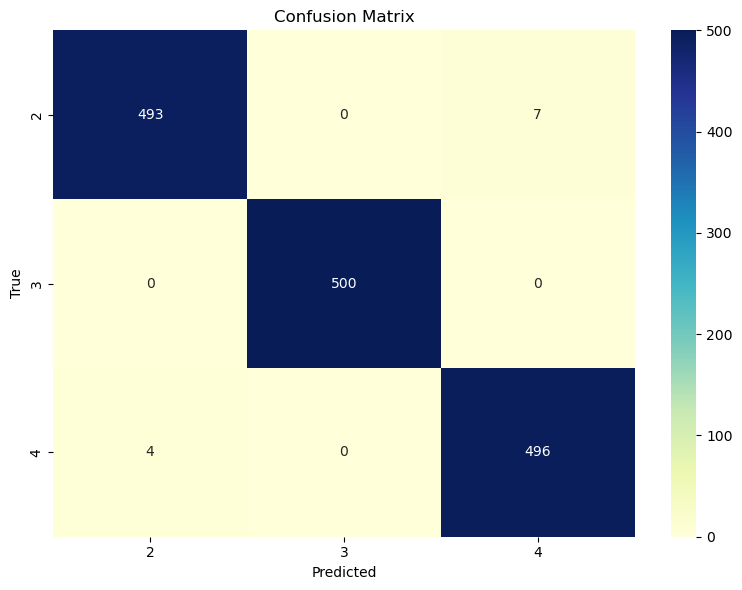

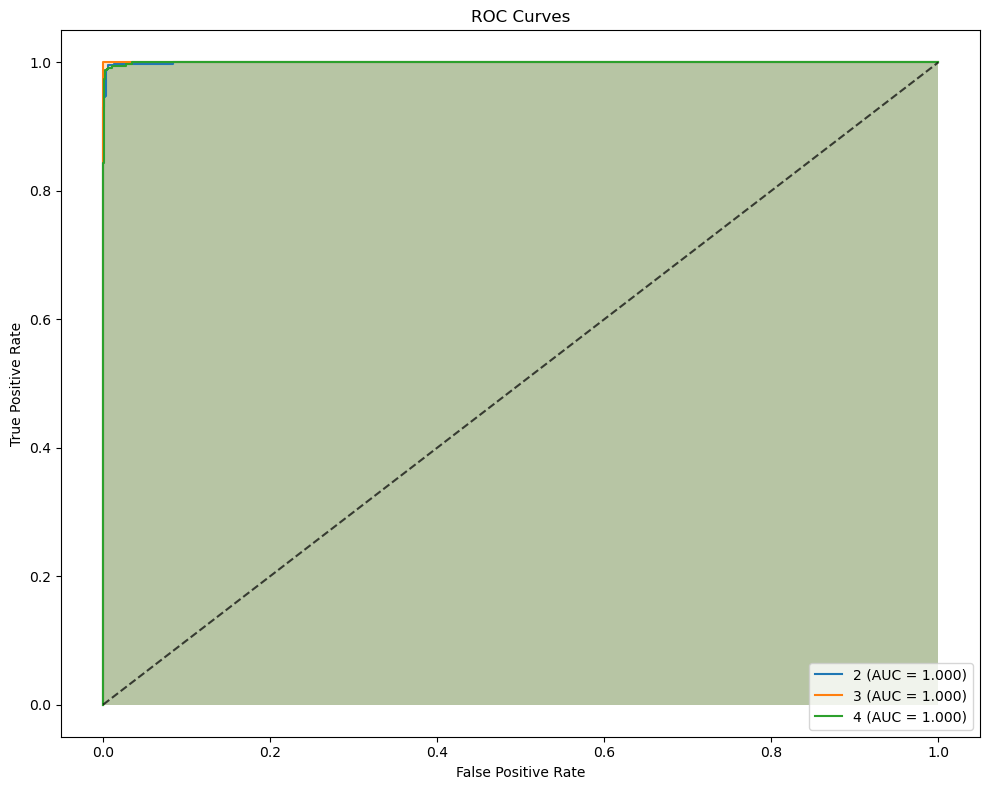

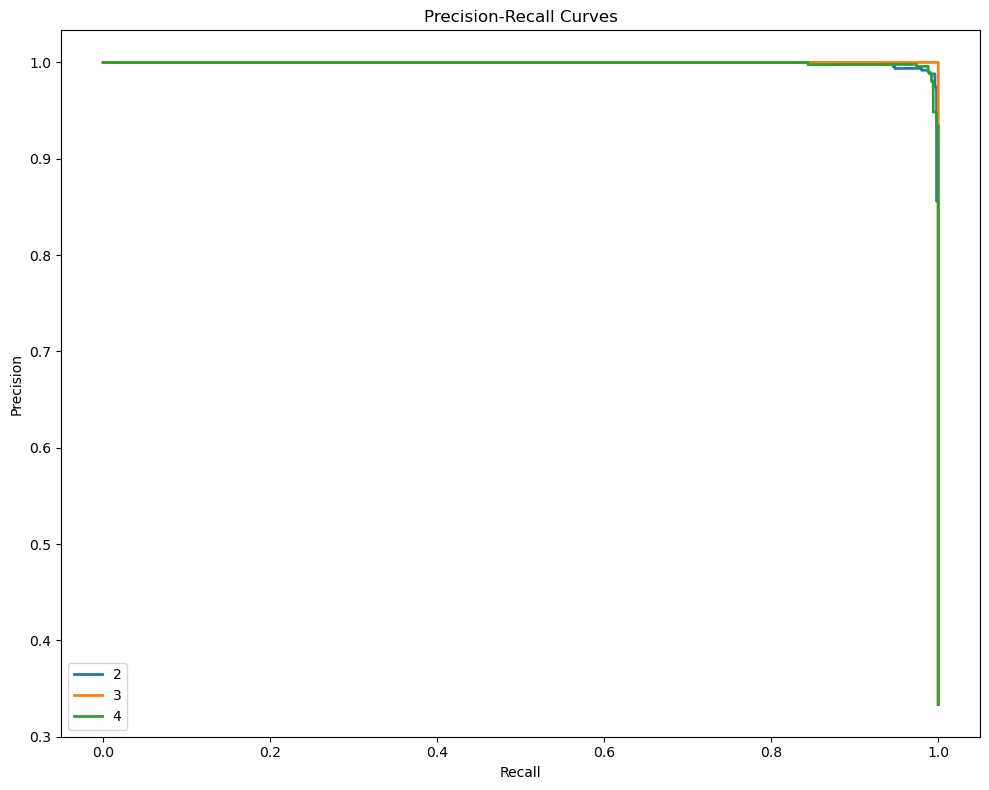

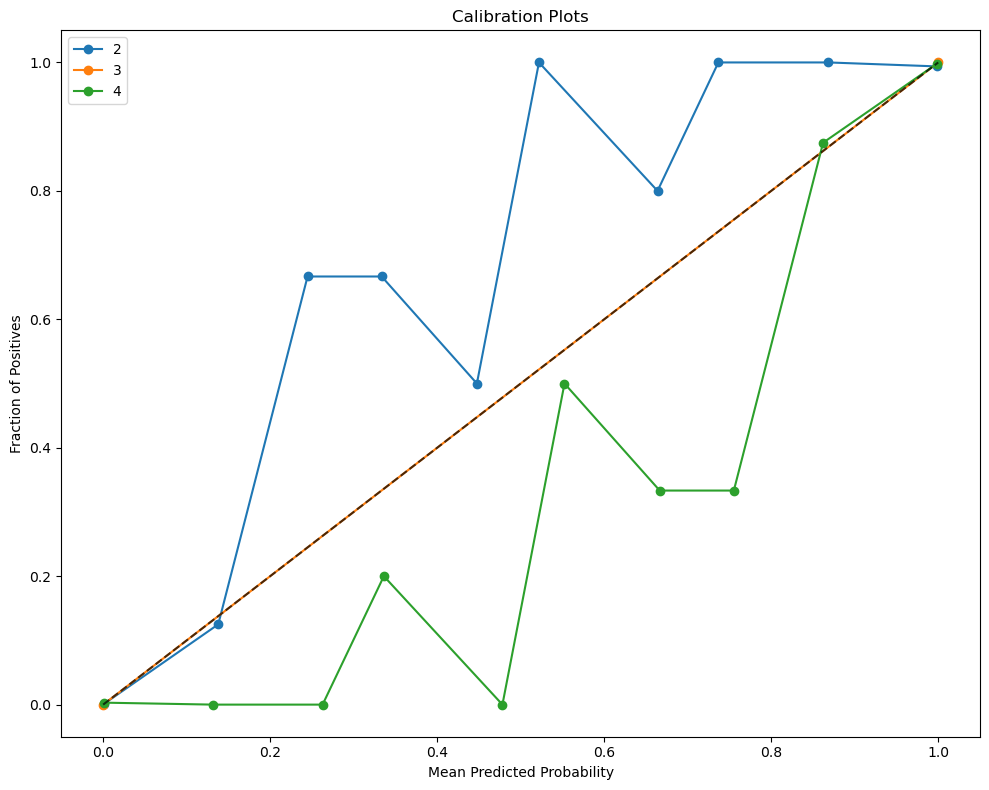

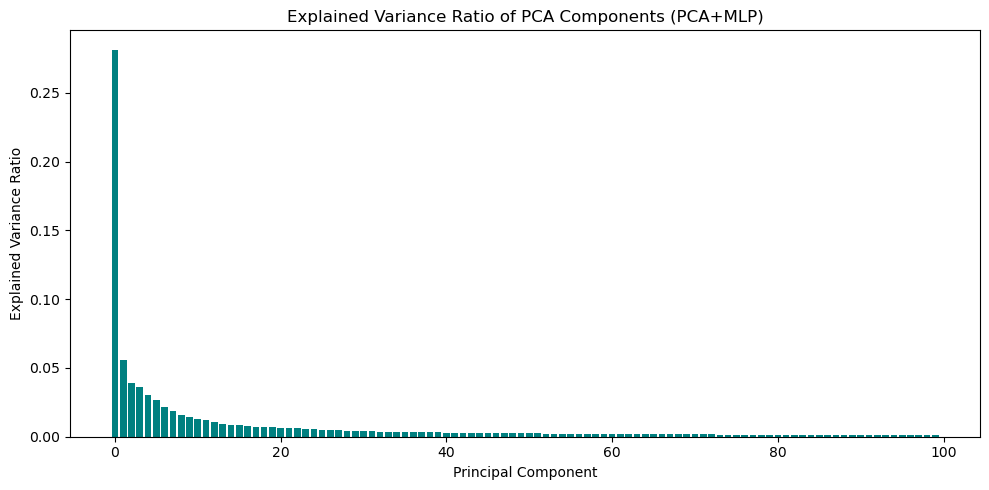

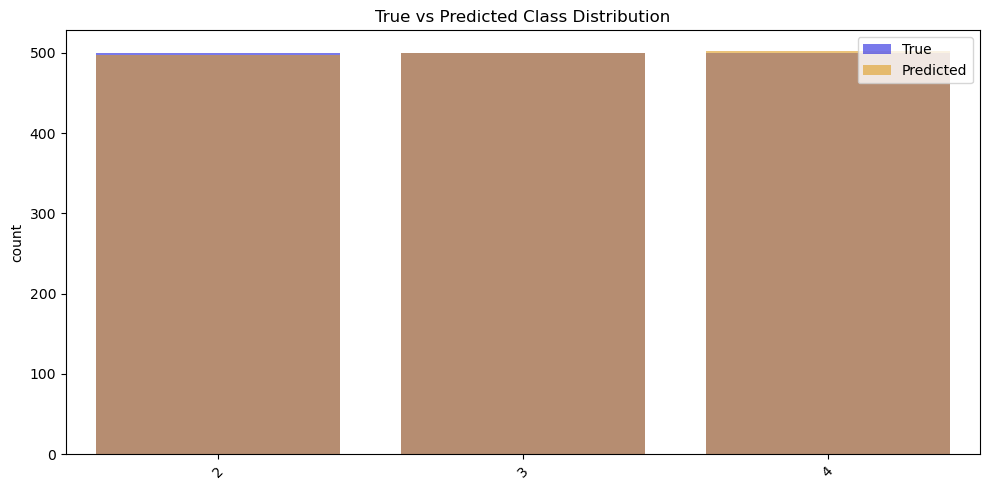

In [72]:
# Visuals of final model

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
import numpy as np

# Predictions & Probabilities
y_pred = soft_voting_final.predict(X_test)
y_proba = soft_voting_final.predict_proba(X_test)

class_names = le.classes_

# --- 1. Confusion Matrix ---
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- 2. ROC Curves with shaded AUC ---
plt.figure(figsize=(10,8))
for i, label in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_enc == i, y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')
    plt.fill_between(fpr, tpr, alpha=0.2)

plt.plot([0,1], [0,1], 'k--', alpha=0.7)
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# --- 3. Precision-Recall Curves ---
plt.figure(figsize=(10,8))
for i, label in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_enc == i, y_proba[:, i])
    plt.plot(recall, precision, lw=2, label=label)

plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. Calibration plot (Reliability curve) for each class ---
plt.figure(figsize=(10,8))
for i, label in enumerate(class_names):
    prob_true, prob_pred = calibration_curve(y_test_enc == i, y_proba[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=label)

plt.plot([0,1], [0,1], 'k--', alpha=0.7)
plt.title('Calibration Plots')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.tight_layout()
plt.show()

# --- 5. PCA explained variance ratio plot ---
pca_mlp_fitted = soft_voting_final.named_estimators_['PCA_MLP']
explained_var = pca_mlp_fitted.pca.explained_variance_ratio_

plt.figure(figsize=(10,5))
plt.bar(range(len(explained_var)), explained_var, color='teal')
plt.title("Explained Variance Ratio of PCA Components (PCA+MLP)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.tight_layout()
plt.show()

# --- 6. True vs Predicted class distribution ---
plt.figure(figsize=(10,5))
sns.countplot(x=class_names[y_test_enc], label='True', color='blue', alpha=0.6)
sns.countplot(x=class_names[y_pred], label='Predicted', color='orange', alpha=0.6)
plt.title("True vs Predicted Class Distribution")
plt.legend(['True', 'Predicted'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
